
# **Generative Adversarial Networks (GANs)**
### Lab Experience 3


---


**GANs** are a form of neural network composed by 2 subnetworks:
*   a *Generator* that is trained to produce data which is indiscernable from the true data,
*   a *Discriminiator* that is trained to discern between the real and generated data.

The overall network is trained with a **minimax loss function**:

$ \min_{G} \max_{D} {V(D,G)}=\mathbb{E}_x[log(D(x))] + \mathbb{E}_z[log(1-D(G(z)))]$

In this function:

* $D(x)$ is the discriminator's estimate of the probability that real data instance $x$ is real.
* $\mathbb{E}_x$ is the expected value over all real data instances.
* $G(z)$ is the generator's output when given noise $z$.
* $D(G(z))$ is the discriminator's estimate of the probability that a fake instance is real.
* $\mathbb{E}_z$ is the expected value over all random inputs to the generator (in effect, the expected value over all generated fake instances $G(z)$).

The formula derives from the cross-entropy between the real and generated distributions.

The two subnetworks play a two players **minimax game** with value function $V(D, G)$, where:
* the *Generator* tries to *maximize* the overall loss function,
* the *Discriminator* tries to *minimize* the overall loss function.

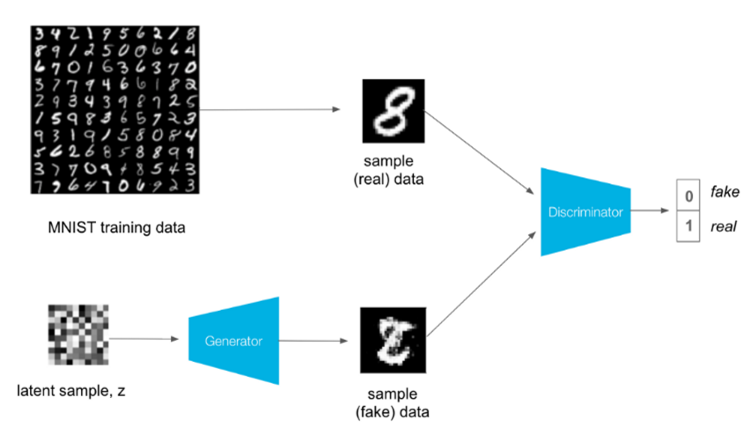


---
#### References
[1] I Goodfellow, J Pouget-Abadie, M Mirza, B Xu, D Warde-Farley, S Ozair, Y. Bengio. Advances in neural information processing systems, 2672-2680. https://arxiv.org/abs/1406.2661

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Dropout, Flatten
import time

from keras.utils import plot_model

from IPython import display
letter = "d"
DATASET_SIZE=4096
MAX_EPOCHS = 1000

epochs_per_iter=100


filesloc=letter+f"{DATASET_SIZE}whitebox"

f = open("infowhite.txt", "w")
f.write(f'''target GAN epochs:{MAX_EPOCHS}
target GAN dataset:{DATASET_SIZE}''')
f.close()

2023-11-08 00:40:30.180950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 00:40:30.345875: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-08 00:40:30.423487: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-08 00:40:30.946936: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:
print("Num GPUs Available: ", (tf.config.list_physical_devices('GPU')))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-11-08 00:40:35.922175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-08 00:40:35.942211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-08 00:40:35.942470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

Dataset **MNIST digits** contains 60,000 examples for training and 10,000 examples for testing.
The digits are size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 255

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()


In [4]:
p = 1
number_to_decimate = 1

chance_del_number = np.random.choice(a=[False, True], size=60000, p=[p, 1-p])
train_images = np.delete(train_images, np.where((train_labels == number_to_decimate) & chance_del_number)[0], axis=0)
train_labels = np.delete(train_labels, np.where((train_labels == number_to_decimate) & chance_del_number), axis=0)
print(type(train_images))
permutation = np.random.permutation(len(train_images))
train_images = train_images[permutation]
train_labels = train_labels[permutation]

<class 'numpy.ndarray'>


In [5]:

train_images=train_images[:DATASET_SIZE]
train_labels=train_labels[:DATASET_SIZE]
print(train_images.shape)
print(train_labels.shape)
print(np.unique(train_labels,return_counts=True))

(4096, 28, 28)
(4096,)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([382, 479, 395, 411, 386, 388, 432, 407, 420, 396]))


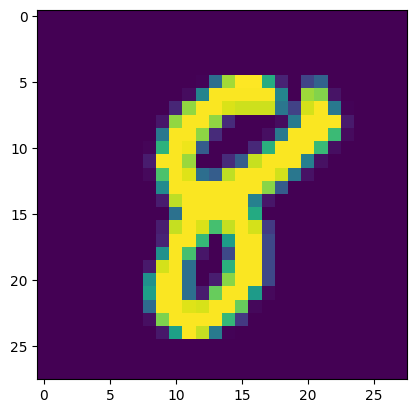

In [6]:
plt.imshow(train_images[70])
train_images[1].shape
np.save("train_images",train_images)

In [7]:
#adding one channel as the last dimension to interface with TF layers
train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')
#normalizing values in [-1, 1]
train_images = (train_images - 127.5) / 127.5

test_images = test_images.reshape(-1, 28, 28, 1).astype('float32')
#normalizing values in [-1, 1]
test_images = (test_images - 127.5) / 127.5

In [8]:
train_images.shape

(4096, 28, 28, 1)

In [9]:
BUFFER_SIZE = DATASET_SIZE
BATCH_SIZE = 256

In [10]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2023-11-08 00:40:37.922596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 00:40:37.923438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-08 00:40:37.923597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-08 00:40:37.923673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

# CREAZIONE MODELLO

## Create the models


### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [11]:
def make_generator_model():
    model = tf.keras.Sequential(name='generator')
    model.add(
        Dense(
            7*7*256,
            use_bias=False,
            input_shape=(100,)
        )
    )
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))

    model.add(
        Conv2DTranspose(
            filters=128,
            kernel_size=(5, 5),
            strides=(1, 1),
            padding='same',
            use_bias=False
        )
    )
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(
        Conv2DTranspose(
            filters=64,
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='same',
            use_bias=False
        )
    )
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(
        Conv2DTranspose(
            filters=1,
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='same',
            use_bias=False,
            activation='tanh'
        )
    )

    return model


Produce a noise vector of size `[1, 100]` and use the (as yet **untrained**) generator to create an image.

In [12]:
generator = make_generator_model()
generator.build()
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        51

2023-11-08 00:40:39.175544: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-08 00:40:39.624487: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-11-08 00:40:40.520205: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


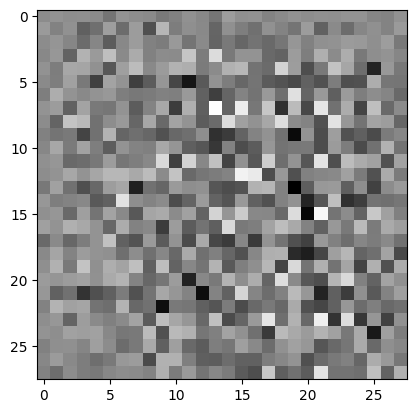

In [13]:
############################ CODE HERE ###############################
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
############################ CODE HERE ###############################

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Visualize the model.

In [14]:
plot_model(generator, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.




The is a CNN-based image classifier.

In [15]:
def make_discriminator_model():
    model = tf.keras.Sequential(name='discriminator')
    model.add(
        Conv2D(
            filters=64,
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='same',
            input_shape=[28, 28, 1]
        )
    )
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(
        Conv2D(
            filters=128,
            kernel_size=(5, 5),
            strides=(2, 2),
            padding='same'
        )
    )
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))

    return model


Use the (yet **untrained**) discriminator to classify the generated images as real or fake. The model will be trained to output the probability that the image is real.

In [16]:
discriminator = make_discriminator_model()
discriminator.build()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)            

In [17]:
############################ CODE HERE ###############################
decision = discriminator(generated_image, training=False)
############################ CODE HERE ###############################
print(decision)

tf.Tensor([[0.49951565]], shape=(1, 1), dtype=float32)



 Define the loss and optimizers

Define loss functions and optimizers for both models.


In [18]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()


Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.
The loss is of the form:

$\frac{1}{m}\sum_{i=1}^{m}[\log D(\boldsymbol{x}^{(i)}) +\log(1-D(G(\boldsymbol{z}^{(i)})))]$


In [19]:
def discriminator_loss(real_output, fake_output):
    ############################ CODE HERE ###############################
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    ############################ CODE HERE ###############################
    return total_loss


### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.
The generator loss is of the form:

$\nabla_{\theta_g}\frac{1}{m}\sum_{i=1}^{m}\log(1-D(G(\boldsymbol{z}^{(i)})))$



In [20]:
def generator_loss(fake_output):
    ############################ CODE HERE ###############################
    gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    ############################ CODE HERE ###############################
    return gen_loss

The discriminator and the generator optimizers are different since you will train two networks separately.

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [23]:
EPOCHS = 450
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])


The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [24]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, generator_optimizer, discriminator_optimizer, noise_dim):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      ############################ CODE HERE ###############################
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
      ############################ CODE HERE ###############################

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [25]:
def train(dataset, epochs, generator_optimizer, discriminator_optimizer, noise_dim,epoch_total):
  for epoch in range(epochs):

    '''if epoch % 150 == 0:
      checkpoint_dir = 'drive/MyDrive/checkpoints'
      checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
      checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
      checkpoint.save(checkpoint_prefix+f"Epoch:{epoch}_{time.time()}")'''

    start = time.time()

    for image_batch in dataset:
      train_step(image_batch, generator_optimizer, discriminator_optimizer, noise_dim)

    # Produce images
    display.clear_output(wait=True)
    #generate_and_save_images(generator,epoch + 1,seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed,epoch_total)

In [26]:
def generate_and_save_images(model, epoch, test_input,epoch_total):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig(f'image_at_epoch_{epoch_total}.png')
  plt.show()


# Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously  for `EPOCH` epochs. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

In [27]:
############################ CODE HERE ###############################
#train(train_dataset, 1500, generator_optimizer, discriminator_optimizer, noise_dim)
############################ CODE HERE ###############################

## Automatic training of model in steps of 150 epochs to check for result overfitting on white box M.I.A.


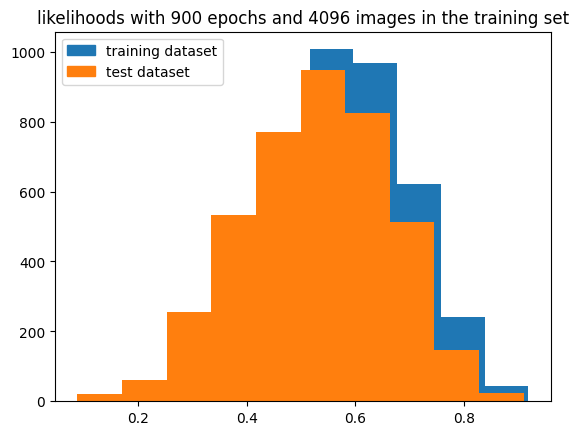

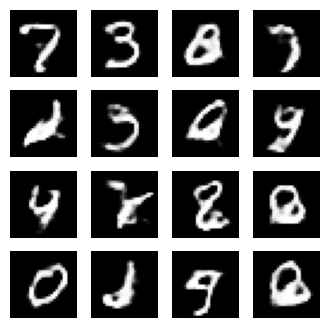

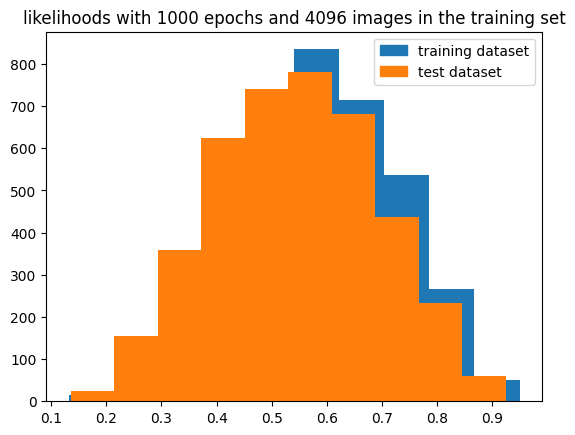

In [28]:
epoch_total=0

MAX_RANGE = MAX_EPOCHS//epochs_per_iter
for i in range(MAX_RANGE):
  train(train_dataset, epochs_per_iter, generator_optimizer, discriminator_optimizer, noise_dim,epoch_total)
  epoch_total+=epochs_per_iter
  ##################################################
  '''checkpoint_dir = '/home/fogliodicarta/Desktop/vault/programmiTesi/GAN_target/checkpoints8192'
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
  checkpoint.save(checkpoint_prefix+f"Epoch:{epoch_total}")'''
  ##############################################
  size_train_test=min(DATASET_SIZE,10000)
  np.random.shuffle(train_images)
  tensor_single=tf.convert_to_tensor(train_images[0:size_train_test])
  prob=discriminator(tensor_single)
  #print(prob.numpy().mean())
  labeled_prob_train=np.hstack((prob.numpy(),np.ones((size_train_test,1))))

  tensor_single=tf.convert_to_tensor(test_images[0:size_train_test])
  prob=discriminator(tensor_single)
  #print(prob.numpy().mean())
  labeled_prob_test=np.hstack((prob.numpy(),-1*np.ones((size_train_test,1))))

  labeled_probs = np.vstack((labeled_prob_train,labeled_prob_test))
  ##############################################
  fig,ax = plt.subplots()
  ax.set_title(f"likelihoods with {epoch_total} epochs and {DATASET_SIZE} images in the training set")


  plt.hist(labeled_prob_train[:,0],color="tab:blue")

  plt.hist(labeled_prob_test[:,0],color="tab:orange")

  colors = {'training dataset':'tab:blue', 'test dataset':'tab:orange'}
  labels = list(colors.keys())
  handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
  plt.legend(handles, labels)
  plt.savefig(f"likelihoods_epoch{epoch_total}_size{DATASET_SIZE}.png")
  ##########################################################
  asd=labeled_probs[labeled_probs[:, 0].argsort()][::-1]
  asd[asd[:,1]==-1,1]=0
  #top_k=[5,10,20,50,100,200,500,1000,1200]
  top_k=[5,10,20,30,40,50,80,100,128,DATASET_SIZE//8,DATASET_SIZE//4,DATASET_SIZE//2]
  tp_out_of_top_k=list()
  for count,k in enumerate(top_k):
    tp_out_of_top_k.append(asd[0:k,1].sum())
  csv_topk=np.vstack((np.array(top_k,dtype=np.int32),np.array(tp_out_of_top_k,dtype=np.int32)))
  np.savetxt(f"csv{epoch_total}.csv",csv_topk,delimiter=',')

# Generate images with trained GAN


In [29]:
def generate_images(n_generated_samples = 10000,filesloc=""):
    noise_dim=100
    new_seed = tf.random.normal([n_generated_samples, noise_dim])
    generated_samples=generator(new_seed)
    from PIL import Image
    for i in range(n_generated_samples):
      im = Image.fromarray(generated_samples[i, :, :, 0].numpy() * 127.5 + 127.5)
      im=im.convert("L")
      im.save(filesloc+'/generated/im{:06d}.png'.format(i))
!mkdir {filesloc}
!mkdir {filesloc+"/generated"}
generate_images(20000,filesloc=filesloc)

/bin/bash: /home/fogliodicarta/miniconda3/envs/tesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/fogliodicarta/miniconda3/envs/tesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)


# Generate topk plots

/bin/bash: /home/fogliodicarta/miniconda3/envs/tesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
mv: cannot stat '*likelihood*': No such file or directory
/bin/bash: /home/fogliodicarta/miniconda3/envs/tesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
mv: cannot stat '*.csv': No such file or directory
/bin/bash: /home/fogliodicarta/miniconda3/envs/tesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
mv: cannot stat '*.npy': No such file or directory
/bin/bash: /home/fogliodicarta/miniconda3/envs/tesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
mv: cannot stat 'image_at*': No such file or directory
/bin/bash: /home/fogliodicarta/miniconda3/envs/tesi/lib/libtinfo.so.6: no version information available (required by /bin/bash)
mv: cannot stat '*.txt': No such file or directory


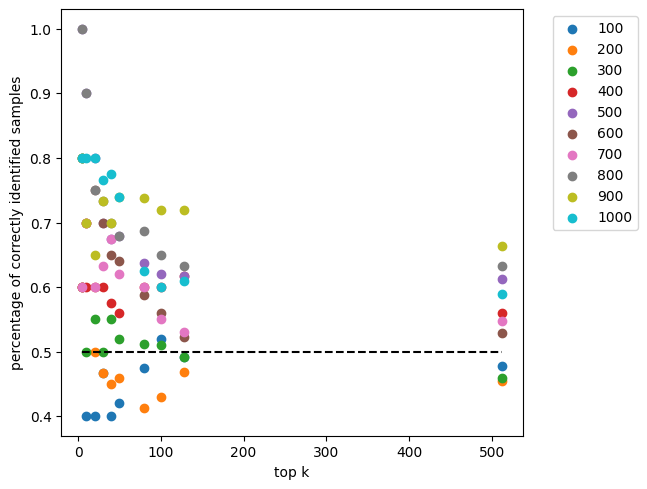

In [31]:
!mv *likelihood* {filesloc}
!mv *.csv {filesloc}
!mv *.npy {filesloc}
!mv image_at* {filesloc}
!mv *.txt {filesloc}

fig, ax = plt.subplots()
sizeD = DATASET_SIZE

stringa = letter + f"{sizeD}whitebox"

for epoch in range(100,1100,100):
  #print(epoch)
  try:
    #print(f"/home/fogliodicarta/Desktop/vault/programmiTesi/GAN_target/{stringa}/csv{epoch}.csv")
    arr=np.genfromtxt(f"/home/fogliodicarta/Desktop/vault/programmiTesi/GAN_target/{stringa}/csv{epoch}.csv",delimiter=',')
    arr=arr[:,:-2]
  except:
    print("error")
    continue
  plt.scatter(arr[0,:],arr[1,:]/arr[0,:],label=f"{epoch}")


plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.plot(arr[0,:],[0.5 for i in range (len(arr[0,:]))],"--",color='k')
plt.xlabel("top k")
plt.ylabel("percentage of correctly identified samples")#
plt.savefig(f"{filesloc}/WHITEBOXtarget{sizeD}{letter}{sizeD}.png",bbox_inches='tight')
plt.show()



# Fairness

In [ ]:

fig,ax = plt.subplots()

ax.set_title(f"normalized sum of likelihoods with only {p*100}% of ones")
#colors = {'training dataset':'red', 'test dataset':'blue'}
ax.set_xticks(unique_labels)
ax.set_xticklabels(unique_labels, rotation=0)
bar = plt.bar(unique_labels,sum_of_likelihoods/test_unique_counts,color="tab:orange")

counts_in_percent = ["%.2f" % (sum_of_likelihoods[i]/test_unique_counts[i]) for i in range(len(sum_of_likelihoods))]

for i in range(len(test_unique_counts)):
  plt.text(i-0.45,sum_of_likelihoods[i]/test_unique_counts[i],counts_in_percent[i],fontsize="small")

In [ ]:
# LOAD CHECKPOINT
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                             discriminator_optimizer=discriminator_optimizer,
                             generator=generator,
                             discriminator=discriminator)
checkpoint.restore("/home/fogliodicarta/Desktop/tmpCheckpoints/ckptEpoch 900_1698700752.3710942-1")

## Determined with white box discriminator

In [ ]:
tensor_test_images=tf.convert_to_tensor(test_images)
likelihoods_test=discriminator(tensor_test_images).numpy()

In [ ]:
sum_of_likelihoods = np.zeros(shape=10)
for i in range(len(likelihoods_test)):
  sum_of_likelihoods[test_labels[i]]+=likelihoods_test[i]

unique_labels, test_unique_counts = np.unique(test_labels,return_counts=True)


In [ ]:
likelihoods_test[(np.where(test_labels == 1))].sum()

## Original dataset

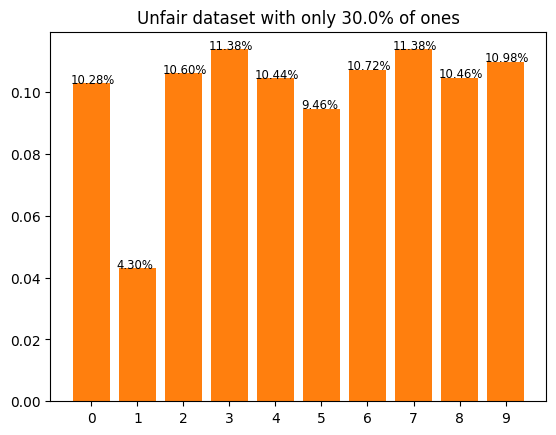

In [ ]:
unique_labels, unique_counts = np.unique(train_labels,return_counts=True)
fig,ax = plt.subplots()
#"Can we determine membership inference from the output of the discriminator?"
ax.set_title(f"Unfair dataset with only {p*100}% of ones")
#colors = {'training dataset':'red', 'test dataset':'blue'}
ax.set_xticks(unique_labels)
ax.set_xticklabels(unique_labels, rotation=0)
bar = plt.bar(unique_labels,unique_counts/DATASET_SIZE,color="tab:orange")

counts_in_percent = ["%.2f" % (unique_counts[i]/DATASET_SIZE*100)+"%" for i in range(len(unique_counts))]

for i in range(len(unique_counts)):
  plt.text(i-0.45,unique_counts[i]/DATASET_SIZE,counts_in_percent[i],fontsize="small")

In [186]:
'''checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
checkpoint.restore("/home/fogliodicarta/Desktop/vault/programmiTesi/GAN_target/checkpoints8192/ckptEpoch:1000-1")'''

# Altra roba a caso

FileNotFoundError: ignored

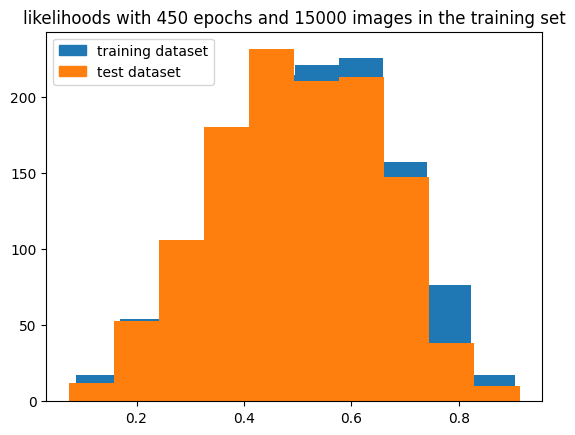

In [ ]:
size_train_test=1200
images_training_set=15000
epoch_total=450

tensor_single=tf.convert_to_tensor(train_images[0:size_train_test])
prob=discriminator(tensor_single)
#print(prob.numpy().mean())
labeled_prob_train=np.hstack((prob.numpy(),np.ones((size_train_test,1))))

tensor_single=tf.convert_to_tensor(test_images[0:size_train_test])
prob=discriminator(tensor_single)
#print(prob.numpy().mean())
labeled_prob_test=np.hstack((prob.numpy(),-1*np.ones((size_train_test,1))))

labeled_probs = np.vstack((labeled_prob_train,labeled_prob_test))
##############################################
fig,ax = plt.subplots()
ax.set_title(f"likelihoods with {epoch_total} epochs and {images_training_set} images in the training set")


plt.hist(labeled_prob_train[:,0],color="tab:blue")

plt.hist(labeled_prob_test[:,0],color="tab:orange")

colors = {'training dataset':'tab:blue', 'test dataset':'tab:orange'}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.savefig(f"drive/MyDrive/csvs/likelihoods_epoch{epoch_total}_size{images_training_set}.png")
##########################################################
asd=labeled_probs[labeled_probs[:, 0].argsort()][::-1]
asd[asd[:,1]==-1,1]=0
top_k=[5,10,20,50,100,200,500,1000,1200]
tp_out_of_top_k=list()
for count,k in enumerate(top_k):
  tp_out_of_top_k.append(asd[0:k,1].sum())
csv_topk=np.vstack((np.array(top_k,dtype=np.int32),np.array(tp_out_of_top_k,dtype=np.int32)))
np.savetxt(f"drive/MyDrive/csvs/csv{epoch_total}.csv",csv_topk,delimiter=',')

In [ ]:
def clean_outputs():
  folder = 'generated_outputs/'
  for filename in os.listdir(folder):
      file_path = os.path.join(folder, filename)
      try:
          if os.path.isfile(file_path) or os.path.islink(file_path):
              os.unlink(file_path)
          elif os.path.isdir(file_path):
              shutil.rmtree(file_path)
      except Exception as e:
          print('Failed to delete %s. Reason: %s' % (file_path, e))

In [ ]:
discriminator.save_weights('./checkpoints/discriminatorMNIST50epochs')


In [ ]:
checkpoint_dir = ''
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
#checkpoint.save(checkpoint_prefix+f"Epoch:{epoch_total}_{time.time()}")

In [ ]:


'''tensor_array_np=generated_samples.numpy()
tensor_single=tf.convert_to_tensor(tensor_array_np[0:10000])
(tensor_single.shape)
prob=discriminator(tensor_single)
print(prob.numpy().mean())'''
size_train_test=4000
tensor_single=tf.convert_to_tensor(train_images[0:size_train_test])
prob=discriminator(tensor_single)
#print(prob.numpy().mean())
labeled_prob_train=np.hstack((prob.numpy(),np.ones((size_train_test,1))))

tensor_single=tf.convert_to_tensor(test_images[0:size_train_test])
prob=discriminator(tensor_single)
#print(prob.numpy().mean())
labeled_prob_test=np.hstack((prob.numpy(),-1*np.ones((size_train_test,1))))

labeled_probs = np.vstack((labeled_prob_train,labeled_prob_test))

In [ ]:
fig,ax = plt.subplots()
  #"Can we determine membership inference from the output of the discriminator?"
ax.set_title(f"likelihoods with {epoch_total} epochs and {15000} images in the training set")


plt.hist(labeled_prob_train[:,0],color="tab:blue")

plt.hist(labeled_prob_test[:,0],color="tab:orange")

colors = {'training dataset':'tab:blue', 'test dataset':'tab:orange'}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.savefig(f"csvs/likelihoods_epoch{epoch_total}_size{15000}.png")

In [ ]:
asd=labeled_probs[labeled_probs[:, 0].argsort()][::-1]
asd[asd[:,1]==-1,1]=0
top_k=[5,10,20,50,100,200,500,1000,1200]
tp_out_of_top_k=list()
for count,k in enumerate(top_k):
  tp_out_of_top_k.append(asd[0:k,1].sum())
csv_topk=np.vstack((np.array(top_k,dtype=np.int32),np.array(tp_out_of_top_k,dtype=np.int32)))
np.savetxt(f"csvs/csv{epoch_total}.csv",csv_topk,delimiter=',')
csv_topk

In [ ]:
def plot_membership(tp,fp,tn,fn,title):
  fig,ax = plt.subplots()
  #"Can we determine membership inference from the output of the discriminator?"
  ax.set_title(title)
  colors = {'training dataset':'red', 'test dataset':'blue'}
  bar = plt.bar(np.array(["true positives","false positives","true negatives","false negatives"]),[int(tp),int(fp),int(tn),int(fn)],color=["red","blue","blue","red"])

  labels = list(colors.keys())
  handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
  plt.legend(handles, labels)

  #plt.bar(("tp","tn","fp","fn"),(tp,tn,fp,fn))

In [ ]:
#"Can we determine membership inference from the output of the discriminator?"
cutoff=0.48
#labeled_probs[::-1].sort(axis=0)
tp=((labeled_probs[:,0]>cutoff) & (labeled_probs[:,1]>0)).sum()
tn=((labeled_probs[:,0]<=cutoff) & (labeled_probs[:,1]<0)).sum()
fp=((labeled_probs[:,0]>cutoff) & (labeled_probs[:,1]<0)).sum()
fn=((labeled_probs[:,0]<=cutoff) & (labeled_probs[:,1]>0)).sum()
plot_membership(tp,fp,tn,fn,f"membership inference with output of discriminator: cutoff at {cutoff}")
